[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Wp-Zhang/HandyRec/blob/master/examples/QuickstartDemo.ipynb)

# Quick-Start

In this demo, we'll use `DSSM` and `DeepFM` to perform candidate generating and ranking on MovieLens1M dataset.

## Prepare

This project is under development and has not been packaged yet😣, thus we have to import it as a local module.

1. download the source code
```bash
git clone https://github.com/Wp-Zhang/HandyRec.git
```

In [1]:
! git clone https://github.com/Wp-Zhang/HandyRec.git

Cloning into 'HandyRec'...
remote: Enumerating objects: 1704, done.
remote: Counting objects: 100% (1704/1704), done.
remote: Compressing objects: 100% (1269/1269), done.
remote: Total 1704 (delta 682), reused 1309 (delta 383), pack-reused 0
Receiving objects: 100% (1704/1704), 20.92 MiB | 27.02 MiB/s, done.
Resolving deltas: 100% (682/682), done.


2. add the project location to system path so that we can import it as a local module

In [2]:
import sys
sys.path.append('./HandyRec/')

The next step is downloading the dataset:
```bash
wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
unzip -o ml-1m.zip
```

In [3]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
!unzip -o ml-1m.zip

--2022-04-15 22:12:34--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./ml-1m.zip’

./ml-1m.zip         100%[===================>]   5.64M  17.9MB/s    in 0.3s    

2022-04-15 22:12:35 (17.9 MB/s) - ‘./ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [4]:
!pip install faiss-gpu #faiss-cpu

     |████████████████████████████████| 85.5 MB 134 kB/s 


## Import modules

In [5]:
from handyrec.data.movielens import MovielensDataHelper
from handyrec.data.utils import gen_sequence
from handyrec.data import PointWiseDataset

from handyrec.layers.utils import sampledsoftmaxloss
from handyrec.models.retrieval import DSSM
from handyrec.models.ranking import DeepFM
from handyrec.features import DenseFeature, SparseFeature, SparseSeqFeature, FeatureGroup, EmbdFeatureGroup, FeaturePool
from handyrec.data.metrics import map_at_k, recall_at_k
from handyrec.models.utils import search_embedding

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import gc

In [6]:
import warnings
warnings.filterwarnings('ignore')

## Prepare data for matching

Load data into a dictionary with three keys: `user`, `item`, and `interact`, then generate a movie watching history sequence with a length of `40` for each user.

In [7]:
retrieve_dh = MovielensDataHelper('./ml-1m/')
data = retrieve_dh.get_clean_data(sparse_features=['gender','occupation','zip','age','year'])
data['inter']['hist_movie'] = gen_sequence(data['inter'], 'user_id', 'movie_id', 40)

Generate movie_id sequence: 100%|██████████| 6040/6040 [00:09<00:00, 668.65it/s] 


In [8]:
user_features = ['user_id', 'gender', 'occupation']
item_features = ['movie_id','genres']
inter_features = ['hist_movie']

Only movies with ratings larger than `3` are treated as 'positive' samples for each user. Every last `10` 'positive' movies of each user are held out for testing and `10%` of the train set is split out for validating.

As we'll use sampled softmax in the training process of the retrieval model, we don't need to generate negative samples by ourselves here.

In [9]:
retrieval_dataset = PointWiseDataset(
    "RetrievalDataset",
    task="retrieval",
    data=data,
    uid_name="user_id",
    iid_name="movie_id",
    inter_name="interact",
    time_name="timestamp",
    threshold=4,
)

retrieval_dataset.train_test_split(10)
retrieval_dataset.train_valid_split(0.1)
retrieval_dataset.gen_dataset(user_features, item_features, inter_features, shuffle=False)

Save inter features: 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


In [10]:
train_data, valid_data, test_data, test_label = retrieval_dataset.load_dataset(
    user_features, item_features, inter_features, 4096
)

Load inter features: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


## Train match model and export embeddings

Initialize a `FeaturePool` instance to store features used for training.

In [11]:
feat_pool1 = FeaturePool()

Get dimension of sparse features:

In [12]:
feature_dim = retrieval_dataset.get_feature_dim(user_features, item_features, [])

Initialize an `EmbdFeatureGroup` instance for item features.

In [13]:
all_item_model_input = {f:np.array(data['item'][f].tolist()) for f in item_features}

retrieve_item_features = [SparseFeature('movie_id', feature_dim['movie_id'], embedding_dim=64)] +\
                [SparseSeqFeature(SparseFeature('genre_id', 19, 64), 'genres', seq_len=6)]
item_feature_group = EmbdFeatureGroup(
    name='item', 
    id_name='movie_id', 
    features=retrieve_item_features, 
    feature_pool=feat_pool1, 
    value_dict=all_item_model_input,
    embd_dim=64
)

Initialize a `FeatureGroup` instance for user features.

In [14]:
retrieve_user_features = [SparseFeature(x, feature_dim[x], 64) for x in user_features] +\
                [SparseSeqFeature(SparseFeature('movie_id', feature_dim['movie_id'], 64), 'hist_movie', 40)]
user_feature_group = FeatureGroup('user', retrieve_user_features, feat_pool1)

Create a DSSM model.

In [15]:
retrieve_model = DSSM(
    user_feature_group, item_feature_group,
    user_dnn_hidden_units=(256,128,64), 
    item_dnn_hidden_units=(128,64), 
    dnn_dropout=0.1,
    dnn_bn=True,
    num_sampled=100
)

Let's take a look at the model structure:

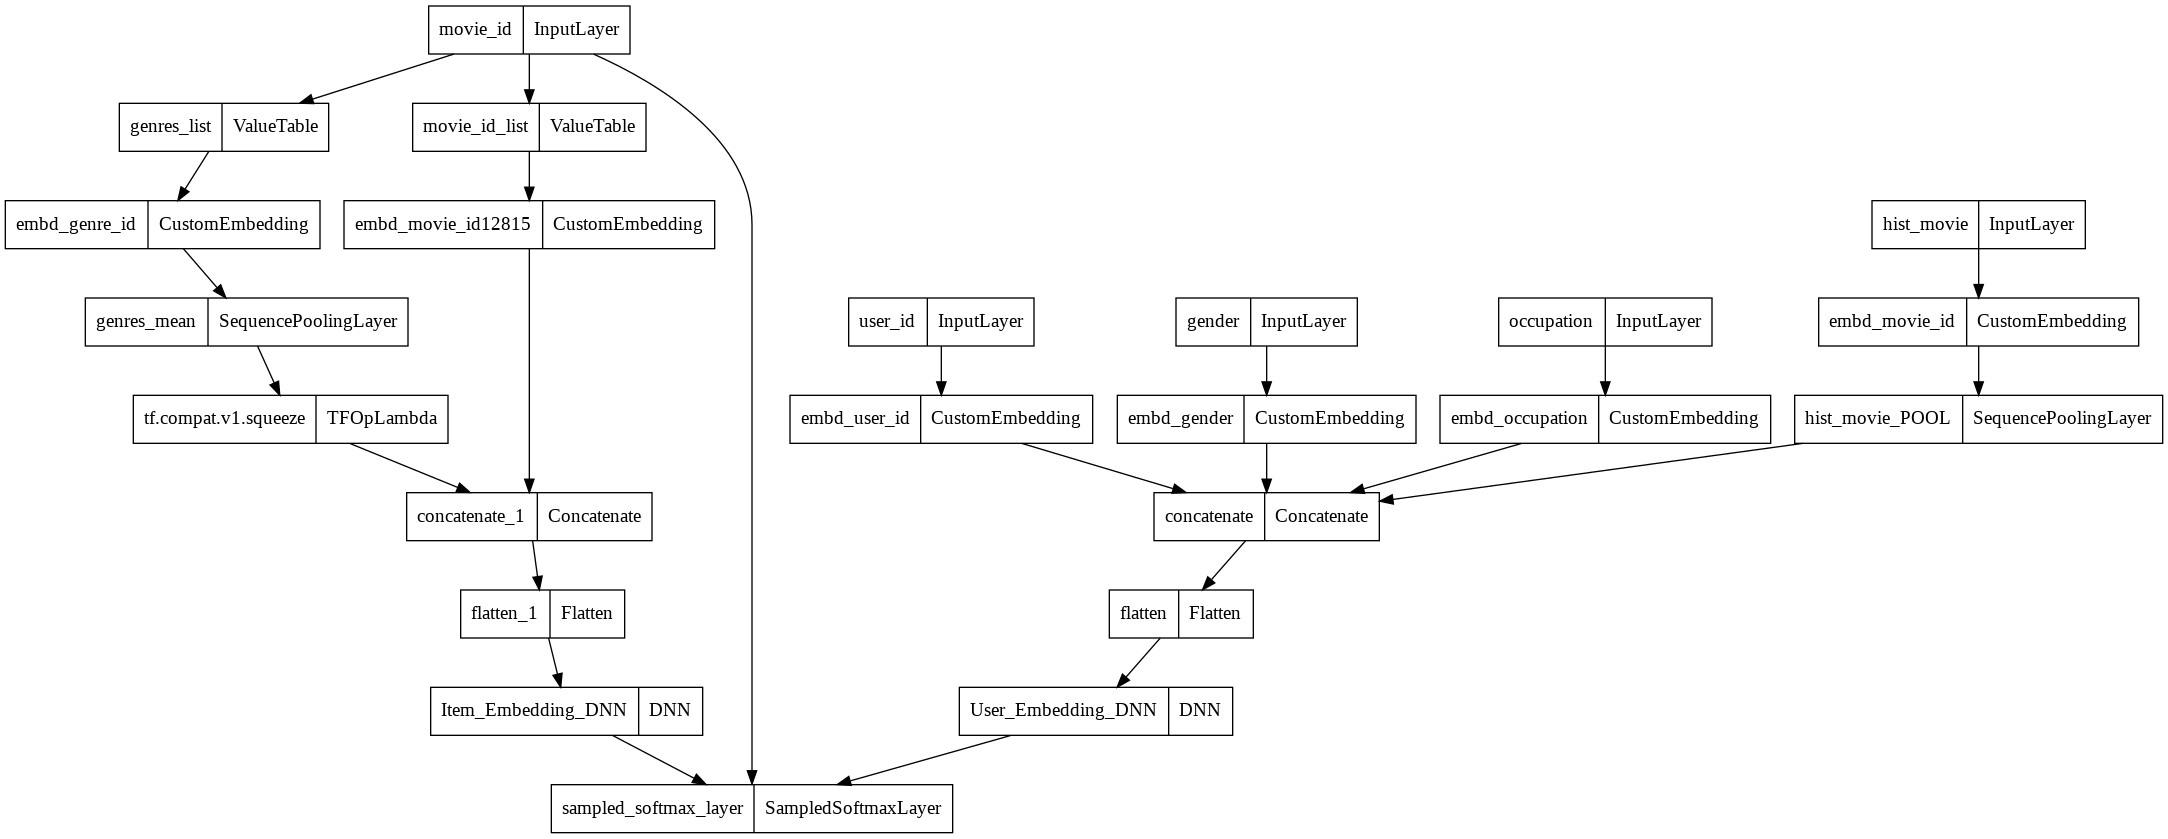

In [16]:
plot_model(retrieve_model)

In [17]:
retrieve_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=sampledsoftmaxloss)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./match_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
history = retrieve_model.fit(
    x=train_data,
    validation_data=valid_data,
    epochs=25,
    callbacks=[early_stop, checkpoint],
)
retrieve_model.load_weights('./match_checkpoint/')

Epoch 1/25
114/114 [==============================] - 11s 42ms/step - loss: 7.3279 - val_loss: 3.8524
Epoch 2/25
114/114 [==============================] - 5s 40ms/step - loss: 3.2380 - val_loss: 3.6875
Epoch 3/25
114/114 [==============================] - 5s 40ms/step - loss: 2.4422 - val_loss: 3.3004
Epoch 4/25
114/114 [==============================] - 5s 40ms/step - loss: 2.0972 - val_loss: 2.6112
Epoch 5/25
114/114 [==============================] - 5s 41ms/step - loss: 1.7308 - val_loss: 1.7159
Epoch 6/25
114/114 [==============================] - 5s 41ms/step - loss: 1.6307 - val_loss: 1.3833
Epoch 7/25
114/114 [==============================] - 5s 41ms/step - loss: 1.4542 - val_loss: 1.2502
Epoch 8/25
114/114 [==============================] - 5s 39ms/step - loss: 1.3861 - val_loss: 1.1054
Epoch 9/25
114/114 [==============================] - 5s 40ms/step - loss: 1.2970 - val_loss: 1.0867
Epoch 10/25
114/114 [==============================] - 5s 41ms/step - loss: 1.2097 - val_l

Get user and movie embeddings:

In [18]:
user_embedding_model = Model(inputs=retrieve_model.user_input, outputs=retrieve_model.user_embedding)
item_embedding_model = Model(inputs=retrieve_model.item_input, outputs=retrieve_model.item_embedding)

user_embs = user_embedding_model.predict(test_data, batch_size=2 ** 15)
item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 15)

print(user_embs.shape)
print(item_embs.shape)

(5923, 64)
(3883, 64)


## Test match model

In [19]:
candidates = search_embedding(
    64, 
    item_embs, 
    user_embs,
    data['item']['movie_id'].values,
    n=100,
    gpu=True
)

In [20]:
map_at_k(test_label, candidates, k=10)

0.01550499264368925

In [21]:
recall_at_k(test_label, candidates, k=10)

0.039186223197703866

In [22]:
recall_at_k(test_label, candidates, k=100)

0.1349653891608982

## Prepare data for ranking

In [23]:
test_user_embs = user_embedding_model.predict(test_data, batch_size=2 ** 15)
test_candidates = search_embedding(
    64, 
    item_embs, 
    test_user_embs,
    data['item']['movie_id'].values,
    n=100,
    gpu=True
)

test_candidates = {
    test_data['user_id'][i] : test_candidates[i]
    for i in range(test_candidates.shape[0])
}

In [24]:
del user_embs, item_embs, train_data, test_user_embs
gc.collect()

3970

For ranking dataset, We'll generate `10` random negative samples for each positive sample.

In [25]:
user_features = ['user_id', 'gender', 'occupation', 'zip', 'age']
item_features = ['movie_id', 'year', 'genres']
inter_features = ['hist_movie']

In [26]:
ranking_dataset = PointWiseDataset(
    "RankingDataset",
    task="ranking",
    data=data,
    uid_name="user_id",
    iid_name="movie_id",
    inter_name="interact",
    time_name="timestamp",
    threshold=4,
)

ranking_dataset.train_test_split(10)
ranking_dataset.negative_sampling(10)
ranking_dataset.train_valid_split(0.1)
ranking_dataset.gen_dataset(user_features, item_features, inter_features, test_candidates)

Save inter features: 100%|██████████| 2/2 [00:43<00:00, 21.78s/it]


In [27]:
train_data, valid_data, test_data, test_label = ranking_dataset.load_dataset(
    user_features, item_features, inter_features, 8192
)

Load inter features: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


In [28]:
feature_dim = ranking_dataset.get_feature_dim(user_features, item_features, [])

## Train rank model and recommend movies

Initialize a `FeaturePool` instance to store features used for training.

In [29]:
feat_pool2 = FeaturePool()

Initialize a `FeatureGroup` instance for features used in FM.

In [30]:
rank_fm_features = [SparseFeature(x, feature_dim[x], 64) for x in user_features] +\
                [SparseSeqFeature(SparseFeature('movie_id', feature_dim['movie_id'], 64), 'hist_movie', 40)] +\
                [SparseFeature(x, feature_dim[x], 64) for x in item_features[:-1]] +\
                [SparseSeqFeature(SparseFeature('genre_id', 19, 64), 'genres',6)]
fm_feature_group = FeatureGroup('FM', rank_fm_features, feat_pool2)

Initialize a `FeatureGroup` instance for features used in DNN.

In [31]:
rank_dnn_feats = rank_fm_features
dnn_feature_group = FeatureGroup('DNN', rank_dnn_feats, feat_pool2)

Create a DeepFM model:

In [32]:
rank_model = DeepFM(
    fm_feature_group, dnn_feature_group, 
    dnn_hidden_units=(256,128,1), dnn_dropout=0.2, l2_dnn=0.2, dnn_bn=True
)

Let's take a look at the model sturcture:

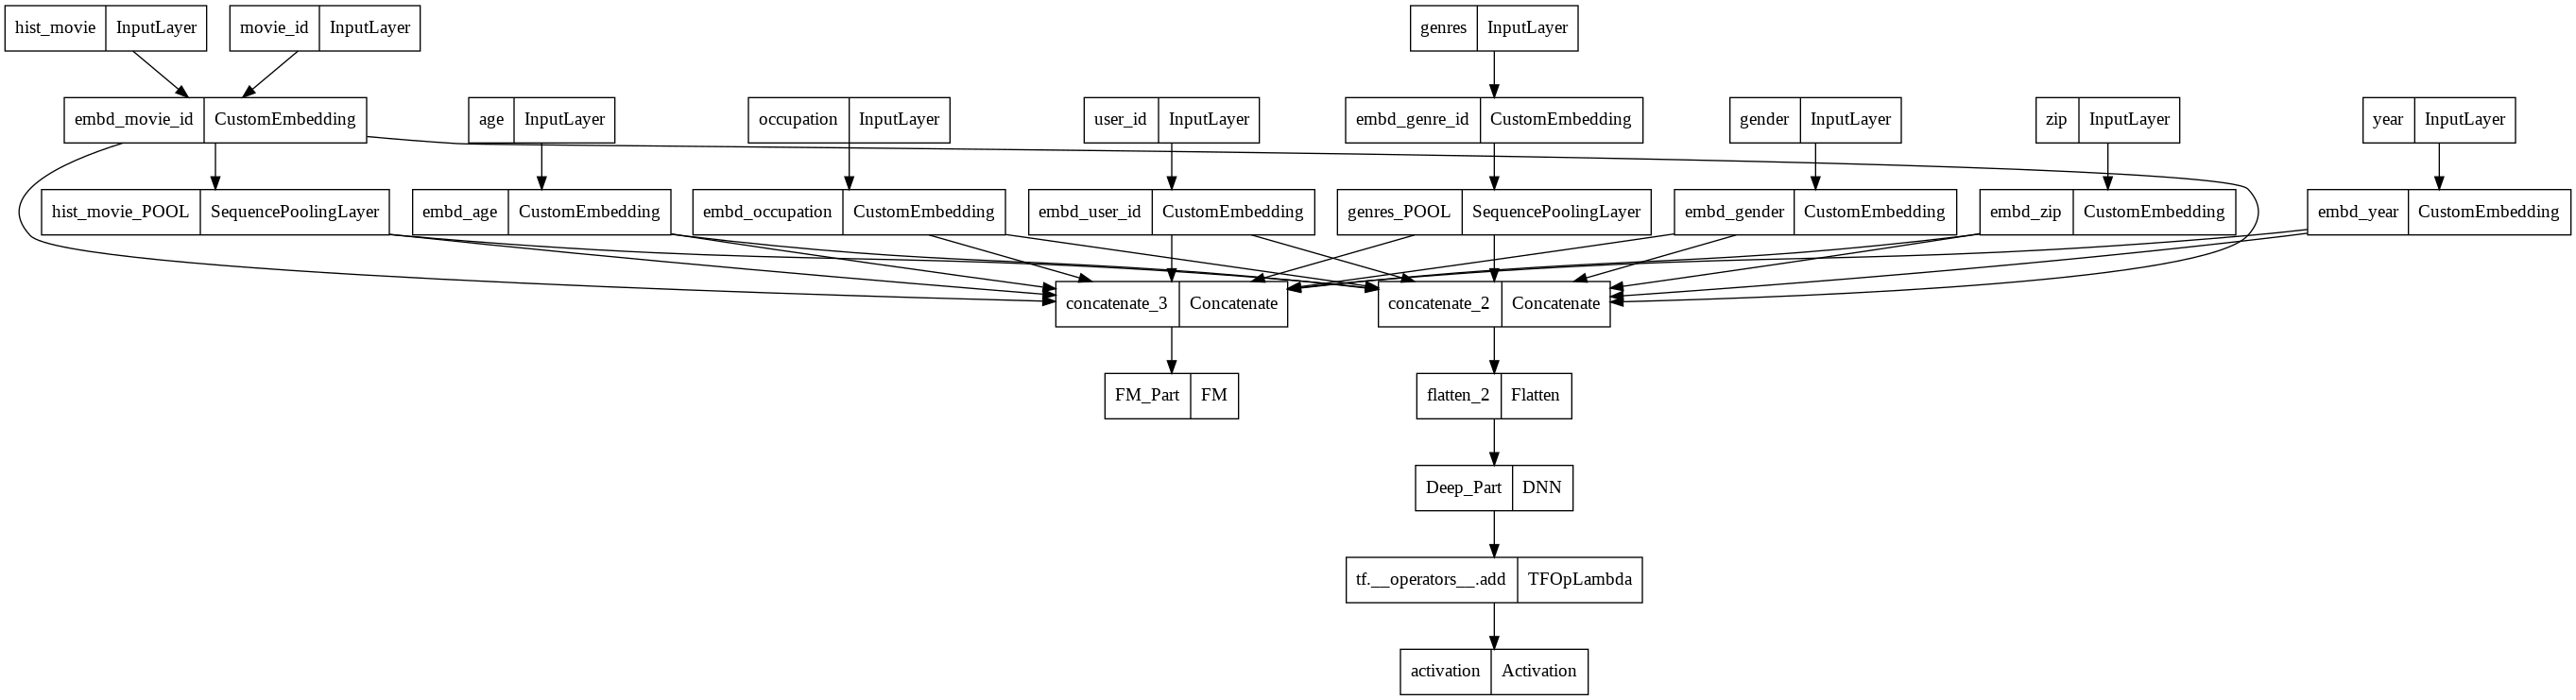

In [33]:
plot_model(rank_model)

In [34]:
rank_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss=binary_crossentropy)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./rank_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
history = rank_model.fit(
    x=train_data, 
    validation_data=valid_data,
    epochs=25,
    callbacks=[early_stop,checkpoint]
)
rank_model.load_weights('./rank_checkpoint/')

Epoch 1/25
623/623 [==============================] - 74s 112ms/step - loss: 10.0025 - val_loss: 0.2401
Epoch 2/25
623/623 [==============================] - 71s 113ms/step - loss: 0.1909 - val_loss: 0.1604
Epoch 3/25
623/623 [==============================] - 73s 116ms/step - loss: 0.1537 - val_loss: 0.1428
Epoch 4/25
623/623 [==============================] - 72s 115ms/step - loss: 0.1350 - val_loss: 0.1350
Epoch 5/25
623/623 [==============================] - 72s 115ms/step - loss: 0.1224 - val_loss: 0.1214
Epoch 6/25
623/623 [==============================] - 73s 116ms/step - loss: 0.1138 - val_loss: 0.1213
Epoch 7/25
623/623 [==============================] - 73s 116ms/step - loss: 0.1078 - val_loss: 0.1228
Epoch 8/25
623/623 [==============================] - 73s 116ms/step - loss: 0.1027 - val_loss: 0.1157
Epoch 9/25
623/623 [==============================] - 74s 117ms/step - loss: 0.0981 - val_loss: 0.1231
Epoch 10/25
623/623 [==============================] - 73s 117ms/step - 

In [35]:
del train_data
gc.collect()

10913

In [36]:
pred = rank_model.predict(test_data, batch_size=8192)

In [37]:
pred_df = pd.DataFrame(columns=['user_id','movie_id','pred'])
pred_df['user_id'] = test_data['user_id']
pred_df['movie_id'] = test_data['movie_id']
pred_df['pred'] = pred

pred_df = pred_df.sort_values(by=['user_id','pred'], ascending=False).reset_index(drop=True)
pred_df = pred_df.groupby('user_id')['movie_id'].apply(list).reset_index()

## Test recommendation result

In [38]:
test_label_df = pd.DataFrame(columns=['user_id','label'])
test_label_df['user_id'] = pd.Series(test_data['user_id']).drop_duplicates()
test_label_df['label'] = test_label.tolist()

In [39]:
test_label_df = pd.merge(test_label_df, pred_df, on=['user_id'], how='left')

In [40]:
map_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.01812087798707755

In [41]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.0488097248016208

In [42]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=100)

0.1349653891608982

**Note**: All parameters in the demo are set for a quick running test purpose, tuning them may lead to a huge increase in model performance.